# Setup

In [13]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib as mpl
mpl.rc('axes', labelsize=30)
mpl.rc('font', size=30)
mpl.rc('xtick', labelsize=22)
mpl.rc('ytick', labelsize=22)
from prophet import Prophet
from sklearn.model_selection import train_test_split

#run functions
# %cd scripts # if needed
%run -i scripts/pandas_startup.py
import scripts.functions as functions # because it's in scripts/functions.py

### Get data

**Option 1**: download data from https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783.

In [29]:
df=pd.read_csv("data/Police_Department_Incident_Reports__2018_to_Present.csv")

**Option 2**: use API

In [27]:
limit = "10"
functions.get_data(limit = limit)

Requesting 10 rows from API...
API request status: <Response [200]>
Got the data and put it in data . It took 0.0 seconds.


,incident_datetime,incident_date,incident_time,incident_year,incident_day_of_week,report_datetime,row_id,incident_id,incident_number,report_type_code,report_type_description,incident_code,incident_category,incident_subcategory,incident_description,resolution,police_district,filed_online,cad_number
0,2021-01-30T09:43:00.000,2021-01-30T00:00:00.000,2022-04-05 09:43:00,2021,Saturday,2021-01-30T09:43:00.000,100069707045,1000697,210038063,VS,Vehicle Supplement,7045,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Truck",Open or Active,Out of SF,NaN,NaN
1,2021-01-29T11:20:00.000,2021-01-29T00:00:00.000,2022-04-05 11:20:00,2021,Friday,2021-01-29T12:19:00.000,100118006244,1001180,216011027,II,Coplogic Initial,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Open or Active,Ingleside,1.0,NaN
2,2021-01-17T11:59:00.000,2021-01-17T00:00:00.000,2022-04-05 11:59:00,2021,Sunday,2021-01-18T04:39:00.000,100189128150,1001891,216012075,II,Coplogic Initial,28150,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Property",Open or Active,Southern,1.0,NaN
3,2021-02-03T05:31:00.000,2021-02-03T00:00:00.000,2022-04-05 05:31:00,2021,Wednesday,2021-02-03T05:31:00.000,100197219400,1001972,210075554,II,Initial,19400,Disorderly Conduct,Other,Gang Related (secondary only),Cite or Arrest Adult,Out of SF,NaN,210340313.0
4,2021-02-03T12:25:00.000,2021-02-03T00:00:00.000,2022-04-05 12:25:00,2021,Wednesday,2021-02-03T13:40:00.000,100226528150,1002265,216012514,II,Coplogic Initial,28150,Malicious Mischief,Vandalism,"Malicious Mischief, Vandalism to Property",Open or Active,Richmond,1.0,NaN
5,2021-02-04T14:57:00.000,2021-02-04T00:00:00.000,2022-04-05 14:57:00,2021,Thursday,2021-02-04T14:57:00.000,100241007045,1002410,210041903,VS,Vehicle Supplement,7045,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Truck",Open or Active,Out of SF,NaN,NaN
6,2021-01-16T21:00:00.000,2021-01-16T00:00:00.000,2022-04-05 21:00:00,2021,Saturday,2021-01-17T12:06:00.000,100257971000,1002579,216012768,II,Coplogic Initial,71000,Lost Property,Lost Property,Lost Property,Open or Active,Central,1.0,NaN
7,2021-02-05T13:50:00.000,2021-02-05T00:00:00.000,2022-04-05 13:50:00,2021,Friday,2021-02-05T13:50:00.000,100269507041,1002695,210049452,VS,Vehicle Supplement,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,Out of SF,NaN,NaN
8,2021-02-06T13:30:00.000,2021-02-06T00:00:00.000,2022-04-05 13:30:00,2021,Saturday,2021-02-06T19:44:00.000,100430106374,1004301,216015154,II,Coplogic Initial,6374,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, >$950",Open or Active,Taraval,1.0,NaN
9,2021-02-09T15:00:00.000,2021-02-09T00:00:00.000,2022-04-05 15:00:00,2021,Tuesday,2021-02-10T10:15:00.000,100469207020,1004692,210091629,VS,Vehicle Supplement,7020,Motor Vehicle Theft,Motor Vehicle Theft,"Vehicle, Stolen & Recovered",Open or Active,Ingleside,NaN,210410059.0


In [19]:
print(len(df))

574951


In [20]:
df.groupby(['Incident Category']).size().sort_values()
df_property_assault = df[df['Incident Category'].isin(["Stolen Property", "Robbery", "Burglary", "Larceny Theft", "Assault"])]

In [21]:
df_property_assault.head()
df_property_assault.isna().sum()
df_property_assault['Incident Date'].sort_values()
daily_incidents = df_property_assault.groupby(['Incident Date']).size().reset_index()

In [22]:
daily_incidents['count'] = daily_incidents.iloc[:,1]
daily_incidents = daily_incidents[['Incident Date', 'count']]
daily_incidents.head()

,Incident Date,count
0,2018/01/01,214
1,2018/01/02,172
2,2018/01/03,203
3,2018/01/04,224
4,2018/01/05,198


In [23]:
# Prophet requires these column names: ds and y.
daily_incidents['ds'] = daily_incidents['Incident Date']
daily_incidents['y'] = daily_incidents['count']
df_prophet = daily_incidents[["ds", "y"]]
df_prophet.head(10).sort_values(by="ds")

,ds,y
0,2018/01/01,214
1,2018/01/02,172
2,2018/01/03,203
3,2018/01/04,224
4,2018/01/05,198
5,2018/01/06,217
6,2018/01/07,190
7,2018/01/08,185
8,2018/01/09,199
9,2018/01/10,172


In [28]:
df_prophet.to_csv("data/daily_incidents_clean.csv")

# Plot historical data

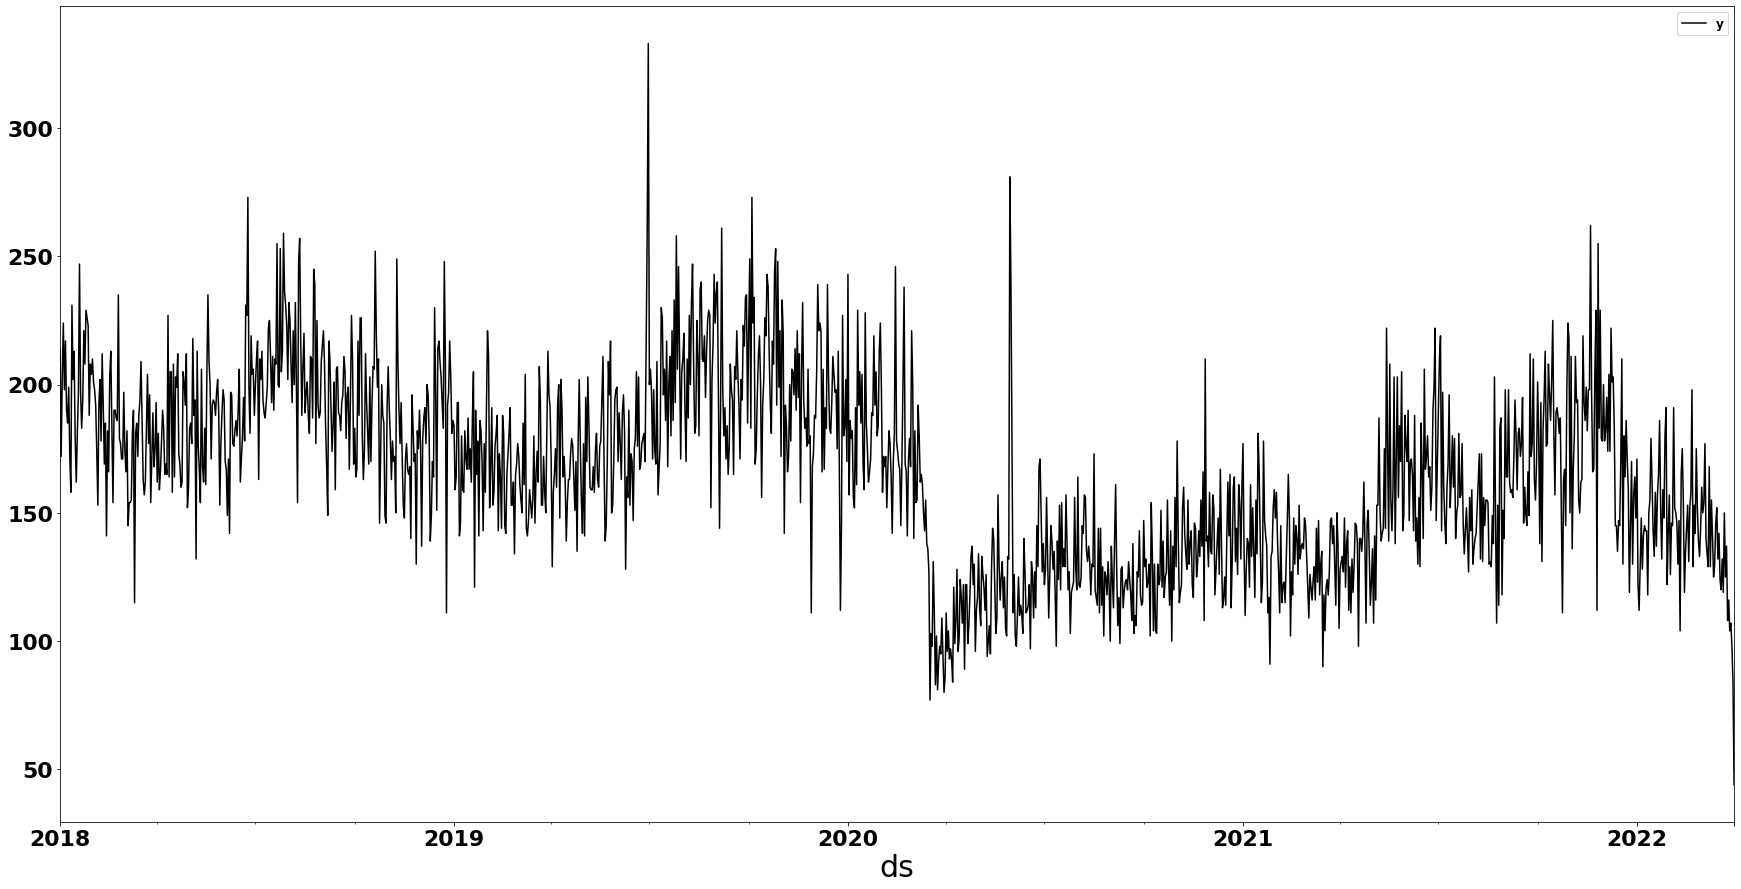

In [213]:
fig, ax = plt.subplots(figsize=(30, 15))

df_prophet.plot('ds', 'y', 
                     color="black", 
                     ax=ax)

plt.show()


# Split data into training and validation (i.e., "test") sets

Make validation set as latest / most recent days.

In [179]:
validation_window = 60  # days
train_df, validation_df = train_test_split(df_prophet, test_size=validation_window, shuffle=False)


In [180]:
assert(((len(train_df) == (len(daily_incidents)-60)) & (len(validation_df) == validation_window)))

In [181]:
train_df.head(2)

,ds,y
0,2018/01/01,214
1,2018/01/02,172


In [182]:
validation_df.head(2)

,ds,y
1492,2022/02/01,126
1493,2022/02/02,146


# Forecast

In [78]:
prophet_config_dict = {
    "weekly_seasonality": True,
    "daily_seasonality": True,
}


In [183]:
prophet_forecaster_object = Prophet(**prophet_config_dict)
prophet_forecaster_object.add_country_holidays("US")
prophet_forecaster_object

If you get `Prophet' object has no attribute 'stan_backend'`, do `pip install pystan==2.19.1.1`


In [184]:
prophet_forecaster_object.fit(train_df)

Initial log joint probability = -11.4192


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3208.44    0.00253801       148.596           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       3215.39   0.000173889       176.656   1.324e-06       0.001      271  LS failed, Hessian reset 
     199       3216.28    0.00369201       306.012      0.5339      0.5339      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3220.71   0.000389777        59.674           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       3221.53   0.000703627       209.603   6.587e-06       0.001      545  LS failed, Hessian reset 
     399       3221.72   4.15052e-06       66.1726      0.3096           1      606   
    Iter      log prob        ||dx||      ||grad||       alpha

In [185]:
train_future_df = prophet_forecaster_object.make_future_dataframe(periods=365, freq="d")
train_future_df.sort_values


<bound method DataFrame.sort_values of              ds
0    2018-01-01
1    2018-01-02
2    2018-01-03
3    2018-01-04
4    2018-01-05
...         ...
1852 2023-01-27
1853 2023-01-28
1854 2023-01-29
1855 2023-01-30
1856 2023-01-31

[1857 rows x 1 columns]>

In [190]:
train_forecast_df = prophet_forecaster_object.predict(train_future_df)

In [191]:
train_forecast_df.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Christmas Day (Observed),...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1852,2023-01-27,202.503531,170.337699,255.876469,171.816019,236.089953,0.0,0.0,0.0,0.0,...,15.726784,15.726784,15.726784,0.218414,0.218414,0.218414,0.0,0.0,0.0,208.847563
1853,2023-01-28,202.568884,159.408104,247.011609,171.790316,236.277545,0.0,0.0,0.0,0.0,...,8.270533,8.270533,8.270533,0.316965,0.316965,0.316965,0.0,0.0,0.0,201.555216
1854,2023-01-29,202.634238,145.127038,234.682489,171.764614,236.511210,0.0,0.0,0.0,0.0,...,-4.439411,-4.439411,-4.439411,0.326692,0.326692,0.326692,0.0,0.0,0.0,188.920353
1855,2023-01-30,202.699591,146.119808,231.761801,171.738911,236.744823,0.0,0.0,0.0,0.0,...,-3.804078,-3.804078,-3.804078,0.246246,0.246246,0.246246,0.0,0.0,0.0,189.540593
1856,2023-01-31,202.764944,140.753217,227.693486,171.650119,236.992369,0.0,0.0,0.0,0.0,...,-10.044868,-10.044868,-10.044868,0.076679,0.076679,0.076679,0.0,0.0,0.0,183.195589


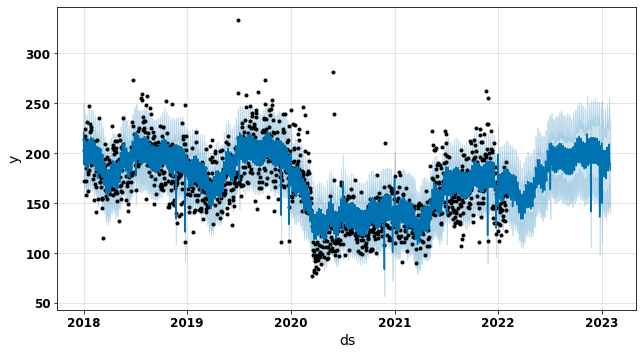

In [197]:
fig1 = prophet_forecaster_object.plot(train_forecast_df)

In [198]:
df_prophet.dtypes

ds    object
y      int64
dtype: object

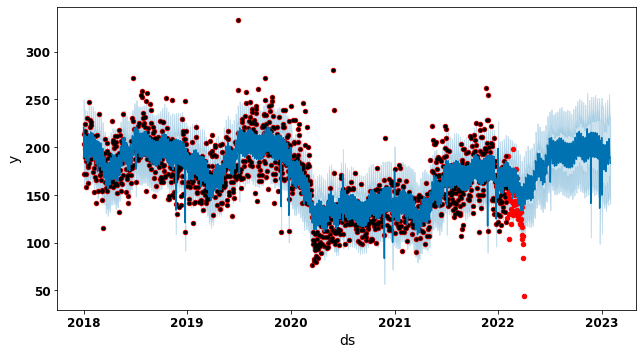

In [204]:
import warnings
warnings.filterwarnings('ignore')
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
prophet_forecaster_object.plot(train_forecast_df)
df_prophet.plot.scatter(x="ds", y="y", color="red", ax=plt.gca())
plt.show()

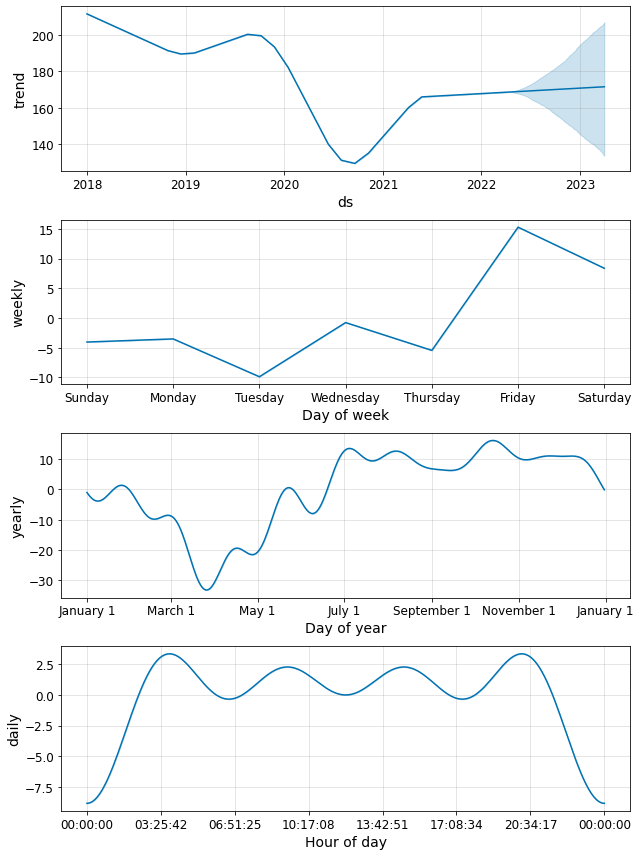

In [105]:
fig2 = prophet_forecaster_object.plot_components(forecast)
